# CS556 Data Security and Privacy
## Homework 4 Differential Privacy II
Filling the code blocks and answer the questions.

In [ ]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# plt.style.use('seaborn-v0_8-whitegrid')
from unittest.mock import patch


adult = pd.read_csv('https://raw.githubusercontent.com/zealscott/CS556/main/adult_with_pii.csv')
adult = adult.dropna()

In [2]:
# varify the downloaded adult dataset
adult.head()

,Name,DOB,SSN,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Brandise Tripony,6/7/1988,150-19-2766,61523,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Brenn McNeely,8/6/1991,725-59-9860,95668,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Dorry Poter,4/6/2009,659-57-4974,25503,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Dick Honnan,9/16/1951,220-93-3811,75387,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Question 1: Exponential mechanism (20 points)
- (5 points) If one wants to get the `Education` group with the maximum number of records with `Age` > 50 with exponential mechanism,
how to design the scores? What is the sensitivity of your score?

    For consistency, we can denote the score of output $r$ based on dataset $X$ as $u(X, r)$

YOUR ANSWER HERE

- (10 points) Implement a differential private function based on basic exponential mechanism to return the `Education` group with the maximum number of records with `Age` > 50.
Clip the `Age` to be in [0, 100]. Also, explain how to set the sensitivity.

    *Recall that the probability of one output is selected is proportional to $\exp(\frac{\epsilon u(X, r)}{2\Delta u}  )$

In [3]:
def basic_exponential(epsilon):
    # YOUR CODE HERE
    # ANSWER

    return None

print(f"The groun with smallest number of older than 50 is {basic_exponential(epsilon=1)}")

The groun with smallest number of older than 50 is None


- (5 points) Can we improve the basic exponential mechanism for the above query? Explain  1. how to improve if your answer is yes 1. why you can make the changes for this query.

    Hint: Some reference for this questions can be
    1. Section 3.4 of "The Algorithmic Foundations of Differential Privacy": https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf
    2. Section 2 of "Understanding the Sparse Vector Technique for Differential Privacy": http://www.vldb.org/pvldb/vol10/p637-lyu.pdf

YOUR ANSWER HERE

## Question 2: DP with machine learning - Gaussian mechanism and gradient perturbation (40 points)

In this question use regularized logistic regression (LR) to predict the `Target` column, which indicate whether the individual has income greate than 50k.

The dataset is pre-processed and loaded by the code below.
For classification, we take the `Target` value as label $y$, where $y=-1$ if <=50k, otherwise it is +1.
Denote the dataset with $n$ samples as $X = [x_1, \ldots, x_n]$ and each $x_i \in \mathbb{R}^d$.
With logistic regression, we represent the probability of label $y$ being either $-1$ or $1$ given parameter vector $w$ and features $x$ as
$\mathbb{P}(y|w, x) = \frac{1}{1 + e^{-y w^T x}}$, where $w^T x$ is the inner product of $w$ and $x$.

The training process is to maximize the (log)likelihood of obtaining such dataset with $w$.
$L(X) = -\log(\prod_{i=1}^{n}\mathbb{P}(y_i|w, x_i)) = \frac{1}{n}\sum_{i=1}^{n}
\log(1 + e^{-y w^T x} ) $.
It is usually simplified by defining $\ell(w; x, y) = \log(1 + e^{-y w^T x} ) $

(Notice that you may see another kind of loss function for LR, it is because their dataset lables are in $\{0, 1\}$ while we use $\{-1, 1\}$ here.)

We are going to use gradient descent as the optimization algorithm to train $w$.
It is not hard to see that the gradient of a sample is
$\frac{\partial \ell(w; x, y)}{\partial w} = \frac{-y x}{1 + e^{w^T x}}$.


In [ ]:
# Load data files
import numpy as np
import urllib.request
import io


url_x = 'https://raw.githubusercontent.com/zealscott/CS556/main/adult_processed_x.npy'
url_y = 'https://raw.githubusercontent.com/zealscott/CS556/main/adult_processed_y.npy'

with urllib.request.urlopen(url_x) as url:
    f = io.BytesIO(url.read())
X = np.load(f)

with urllib.request.urlopen(url_y) as url:
    f = io.BytesIO(url.read())
y = np.load(f)

In [5]:
# Split data into training and test sets
training_size = int(X.shape[0] * 0.8)

X_train = X[:training_size]
X_test = X[training_size:]

y_train = y[:training_size]
y_test = y[training_size:]

print('Train and test set sizes:', len(y_train), len(y_test))

Train and test set sizes: 36176 9044


In [6]:
# Some useful functions

def loss(w, xi, yi):
    exponent = - yi * (xi.dot(w))
    return np.log(1 + np.exp(exponent))


def gradient(w, xi, yi):
    exponent = yi * (xi.dot(w))
    return - (yi*xi) / (1+np.exp(exponent))


def predict(xi, w, bias=0):
    label = np.sign(xi @ w + bias)
    return label


def test_accuracy(w):
    return np.sum(predict(X_test, w) == y_test)/X_test.shape[0]

def train_accuracy(w):
    return np.sum(predict(X_train, w) == y_train)/X_train.shape[0]


- (5 points) First, let's implement a clean training of logistic regrssion with the training dataset (`X_train` and `y_train`).
Fill in the missing part below and run the plotting code.

In [7]:
def gradient_descent(iterations, X_train, y_train):
    w = np.zeros(X_train.shape[1])
    # Strictly speaking, we need to apply Laplace mechanism to estimate the total number of users in dataset
    n = X_train.shape[0]
    # The following two are used to keep track of the training information
    itr_losses = []
    train_accuracies = []


    for i in range(iterations):
        cur_loss = np.average([loss(w, xi, yi) for xi, yi in zip(X_train,y_train)])
        cur_acc = train_accuracy(w)
        itr_losses.append(cur_loss)
        train_accuracies.append(cur_acc)
        if i % 10 == 0:
            print(f"training iteration: {i}")

        # YOUR CODE HERE

    return w, itr_losses, train_accuracies



training iteration: 0
training iteration: 10
training iteration: 20
training iteration: 30
training iteration: 40


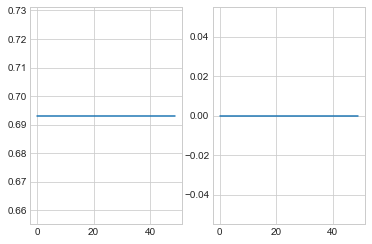

In [8]:
# use your function to train
iterations = 50
w, itr_losses, train_accuracies = gradient_descent(iterations, X_train, y_train)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(iterations), itr_losses, label='training loss' )
ax2.plot(np.arange(iterations), train_accuracies, label='training accuracy')
plt.show()

* (5 points)  It is easy to see that the gradient w.r.t each sample is not bounded in the training iterations,
so the sensitivity of DP for the gradient decent is not bounded as well.
To encounter such problem, a typical solution is called "gradient clipping".
We need to clip the gradient w.r.t EACH SAMPLE (NOT the average gradient!) so that its L2 norm is at most $\theta$.
Implement your `gradient_clipping` function below.

In [9]:
def gradient_clipping(raw_gradient, theta):
    # YOUR CODE HERE

    return None


* (5 points)  Implement the Gaussian mechanism with input parameters consist of a vector, sensitivity, $\epsilon$, $\delta$.
The return should the vector with appropriated additive Gaussian noise.

In [10]:
def gaussian_mech_vec(v, sensitivity, epsilon, delta):
    # YOUR CODE HERE
    return None


* (10 points) Implement your private LR training function below.
    - [Naive composition of privacy budgets] We consider only the naive sequntial composition of privacy budget here.
    Namely, if there are two mechanisms and $M_1$ is ($\epsilon_1, \delta_1$)-private and $M_2$ is ($\epsilon_2, \delta_2$)-private,
    then the privacy loss of $M_2(M_1(X, aux_1), X, aux_2)$ is ($\epsilon_1 + \epsilon_2, \delta_1 + \delta_2$)-private.
    The $aux$ denotes any auxiliary input.
    So if you decide there is $T$ iterations, each iteration should satisfy ($\frac{\epsilon}{T}, \frac{\delta}{T}$)-DP.
    - [Decrease of step sizes] Different from the gradient descent above, the injected noise to the gradient can prevent $w$ to converge.
    A solution is the step size decreases as the number of iteration increases, similar as Stochastic Gradient Descent (SGD).
    You can let the step size decrease linearly in your implementation.

In [11]:
def dp_gradient_descent(iterations, X_train, y_train, epsilon, delta, theta):
    w = np.zeros(X_train.shape[1])
    # Strictly speaking, we need to apply Laplace mechanism to estimate the total number of users in dataset
    n = X_train.shape[0]
    # The following two are used to keep track of the training information
    itr_losses = []
    train_accuracies = []
    step_size = 0.1

    for i in range(iterations):
        cur_loss = np.average([loss(w, xi, yi) for xi, yi in zip(X_train,y_train)])
        cur_acc = train_accuracy(w)
        itr_losses.append(cur_loss)
        train_accuracies.append(cur_acc)
        if i % 10 == 0:
            print(f"training iteration: {i}")

        # YOUR CODE HERE


    return w, itr_losses, train_accuracies

training iteration: 0


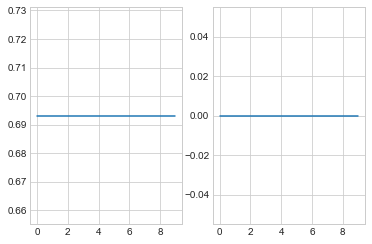

In [12]:
# use your private function to train
iterations = 10
epsilon = 2
delta = 1e-4
theta = 1
w, itr_losses, train_accuracies = dp_gradient_descent(iterations, X_train, y_train, epsilon, delta, theta)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(iterations), itr_losses, label='training loss' )
ax2.plot(np.arange(iterations), train_accuracies, label='training accuracy')
plt.show()


* (15 points) Given fixed $\epsilon$ and $\delta$, the tunable parameters in the training are clipping threshold $\theta$ and the number of iterations iteration.
    - Plot the TESTING accuracies (use the testing dataset) of different thresholds listed below, and discuss the potential trade-offs based on your observation.
    - Plot the TESTING accuracies (use the testing dataset) of different thresholds listed below, and discuss the potential trade-offs based on your observation.

In [13]:
thetas = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
possible_T = [1, 2, 5, 10, 15, 20]
default_iterations = 10
default_theta = 1
epsilon = 2
delta = 1e-4

# YOUR CODE HERE
# train the LR with different parameters
# fig, (ax1, ax2) = plt.subplots(1, 2)
# ax1.plot(thetas, thetas2accuracies, label='training loss' )
# ax2.plot(possible_T, T2accuracies, label='training accuracy')
# plt.legend()
# plt.show()

## Question 3: Local differential privacy (LDP) (40 points)

We can simulate the local differential privacy mechanisms with the adult dataset.
The LDP protocols provides strictly stronger privacy protection for user data,
but usually suffers decline in terms of utility.

* (10 points)
The most basic LDP mechanism maybe the Generalized Random Response (GRR),
which can help data aggregator to estimate the frequencies of categorical values.
Assume that the input domain is $\mathcal{D}$ and its size $|\mathcal{D}| = d$.

    - (Local randomization) For each user's input, $v$, GRR randomize the input value in the following way

    $
    Pr[GRR(v) = v'] = \begin{cases}
        p = \frac{e^{\epsilon}}{e^{\epsilon} + d - 1} & \text{if } v = v' \\
        q = \frac{1}{e^{\epsilon} + d - 1} & \text{otherwise, i.e. } v'\in \mathcal{D}, v\neq v'
    \end{cases}
    $

    - (Aggregation & estimate)
    After aggregation, one can learn the count of some reported value $v$ and denoted as $C(v)$.
    Then the unbiased frequency estimate of $v$ is $\hat{f}(v) = \frac{C(v) - n q}{p - q}$.

    - Implement the simulation GRR for the "Education" attributes.
    By simulation, it means you do NOT need to implement the real network code sending/aggregating.
    Using only the Numpy function to simulate the randomization and computation is enough, no need to make it complicated.

In [14]:
# preprocess the Education attribute
Education_records = adult['Education'].astype("category")
print(Education_records)
encode_mapping = dict( enumerate(Education_records.cat.categories ) )
print("encoding mapping:", encode_mapping)
encoded_edu_records = Education_records.cat.codes.to_numpy()
print("encoded records:", encoded_edu_records)
print("true counts:", np.unique(encoded_edu_records, return_counts=True))

def grr_simulation(records, epsilon):
    d = len(encode_mapping)
    n = len(records)
    estimate_freq = np.zeros(d)
    # YOUR CODE HERE (randomization part)

    # YOUR CODE HERE (unbiased estimation part)

    return estimate_freq


print(grr_simulation(encoded_edu_records, 2))

0         Bachelors
1         Bachelors
2           HS-grad
3              11th
4         Bachelors
            ...    
32556    Assoc-acdm
32557       HS-grad
32558       HS-grad
32559       HS-grad
32560       HS-grad
Name: Education, Length: 30162, dtype: category
Categories (16, object): ['10th', '11th', '12th', '1st-4th', ..., 'Masters', 'Preschool', 'Prof-school', 'Some-college']
encoding mapping: {0: '10th', 1: '11th', 2: '12th', 3: '1st-4th', 4: '5th-6th', 5: '7th-8th', 6: '9th', 7: 'Assoc-acdm', 8: 'Assoc-voc', 9: 'Bachelors', 10: 'Doctorate', 11: 'HS-grad', 12: 'Masters', 13: 'Preschool', 14: 'Prof-school', 15: 'Some-college'}
encoded records: [ 9  9 11 ... 11 11 11]
true counts: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int8), array([ 820, 1048,  377,  151,  288,  557,  455, 1008, 1307, 5044,  375,
       9840, 1627,   45,  542, 6678]))
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


* (10 points)
GRR is proved far from the optimal solution when $\epsilon$ is small or domain size $d$ is large.
An improved LDP mechanism call Optimized Unary Encoding (OUE) has been shown outperforms GRR.
W.L.G., we assume that the input domain is $\mathcal{D}=\{0, 1, 2, \ldots, d-1\}$.
    - (Local randomization) Unary encoding codes the input value $v$ to a unit vector $\mathbf{B}$ with only $\mathbf{B}[v]=1$ and all other elements are set to 0.
    OUE randomizes the unary encoding and outputs vector $\mathbf{B}'$ in the following way:

    $
    Pr[\mathbf{B}'[v] = 1] = \begin{cases}
        p = \frac{1}{2} & \text{if } \mathbf{B}[v] = 1 \\
        q = \frac{1}{e^{\epsilon} + 1} & \text{if } \mathbf{B}[v] = 0
    \end{cases}
    $

    - (Aggregation & estimate) The aggregate then can sum all the report vectors. The unbiased frequencies vector is estimated as

    $
        f = \frac{\sum_{i\in [n]} \mathbf{B}'_{i} - nq}{p - q}
    $

    - Implement the simulation of OUE method in the following code block.

In [18]:
def oue_simulation(records, epsilon):
    d = len(encode_mapping)
    n = len(records)
    estimate_freq = np.zeros(d)

    # YOUR CODE HERE (randomization part)

    # YOUR CODE HERE (unbiased estimation part)
    return None

# verify whether the results is unbiased
results = []
for _ in range(50):
    results.append(oue_simulation(encoded_edu_records, 1))
# print(np.average(results, axis=0))

* (10 points) Compares the average L2 errors of GRR and OUE with different privacy budgets, plot the results.
Summarize your findings.

In [16]:
epsilons = [0.5, 1.0, 1.5, 2, 2.5, 3.0, 3.5, 4.0]

# YOUR CODE HERE

# plt.plot(epsilons, avg_grr_errors, label='GRR' )
# plt.plot(epsilons, avg_oue_errors, label='OUE')
# plt.legend()
# plt.show()

YOUR ANSWER HERE (Summarize your findings.)

* (10 points) Compares the average L2 errors LDP approaches with the histogram generated by Laplace mechanism.
Summarize your findings and try to explain why LDP approaches have poorer utility.
    - Hint: you can analyze the variance of the frequency estimates.

In [17]:
# YOUR CODE HERE
# plt.plot(epsilons, avg_grr_errors, label='GRR' )
# plt.plot(epsilons, avg_oue_errors, label='OUE')
# plt.legend()
# plt.show()

YOUR ANSWER HERE (Summarize your findings, explain why)
